In [1]:
!pip install sportsdataverse
import sportsdataverse as sdv
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 31.0 MB/s eta 0:00:00


In [2]:
df= sdv.mbb.load_mbb_team_boxscore(seasons=range(2021,2022))
df=df.to_pandas()
def flagging_home(x):
    if x =="home":
      return 1
    else:
      return 0
df['home']=df['team_home_away'].apply(flagging_home)
df.sort_values(by=['game_id','home'],inplace=True)
df.rename(index=df['game_id'],inplace=True)
features=["field_goals_made","field_goals_attempted",
          'three_point_field_goals_made','three_point_field_goals_attempted',
          'free_throws_made','free_throws_attempted',
          'offensive_rebounds','defensive_rebounds',
          'assists','blocks',
          'steals','turnovers',
          'fouls','team_score'
          ]


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


In [3]:
df

,game_id,season,season_type,game_date,game_date_time,team_id,team_uid,team_slug,team_location,team_name,...,opponent_team_location,opponent_team_name,opponent_team_abbreviation,opponent_team_display_name,opponent_team_short_display_name,opponent_team_color,opponent_team_alternate_color,opponent_team_logo,opponent_team_score,home
401252483,401252483,2021,2,2020-12-12,2020-12-12 17:00:00-05:00,2229,s:40~l:41~t:2229,florida-international-panthers,Florida International,Panthers,...,North Florida,Ospreys,UNF,North Florida Ospreys,North Florida,004B8D,babcbe,https://a.espncdn.com/i/teamlogos/ncaa/500/245...,80,0
401252483,401252483,2021,2,2020-12-12,2020-12-12 17:00:00-05:00,2454,s:40~l:41~t:2454,north-florida-ospreys,North Florida,Ospreys,...,Florida International,Panthers,FIU,Florida International Panthers,FIU,091731,c5960c,https://a.espncdn.com/i/teamlogos/ncaa/500/222...,77,1
401252508,401252508,2021,2,2021-01-30,2021-01-30 18:00:00-05:00,66,s:40~l:41~t:66,iowa-state-cyclones,Iowa State,Cyclones,...,Mississippi State,Bulldogs,MSST,Mississippi State Bulldogs,Mississippi St,762123,c8c8c8,https://a.espncdn.com/i/teamlogos/ncaa/500/344...,95,0
401252508,401252508,2021,2,2021-01-30,2021-01-30 18:00:00-05:00,344,s:40~l:41~t:344,mississippi-state-bulldogs,Mississippi State,Bulldogs,...,Iowa State,Cyclones,ISU,Iowa State Cyclones,Iowa State,822433,fdca2f,https://a.espncdn.com/i/teamlogos/ncaa/500/66.png,56,1
401252509,401252509,2021,2,2021-02-02,2021-02-02 19:00:00-05:00,277,s:40~l:41~t:277,west-virginia-mountaineers,West Virginia,Mountaineers,...,Iowa State,Cyclones,ISU,Iowa State Cyclones,Iowa State,822433,fdca2f,https://a.espncdn.com/i/teamlogos/ncaa/500/66.png,72,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401312698,401312698,2021,3,2021-03-23,2021-03-23 17:30:00-04:00,324,s:40~l:41~t:324,coastal-carolina-chanticleers,Coastal Carolina,Chanticleers,...,Stetson,Hatters,STET,Stetson Hatters,Stetson,0a5640,56854e,https://a.espncdn.com/i/teamlogos/ncaa/500/56.png,72,1
401312699,401312699,2021,3,2021-03-23,2021-03-23 20:00:00-04:00,91,s:40~l:41~t:91,bellarmine-knights,Bellarmine,Knights,...,Pepperdine,Waves,PEPP,Pepperdine Waves,Pepperdine,003A72,dc762f,https://a.espncdn.com/i/teamlogos/ncaa/500/249...,82,0
401312699,401312699,2021,3,2021-03-23,2021-03-23 20:00:00-04:00,2492,s:40~l:41~t:2492,pepperdine-waves,Pepperdine,Waves,...,Bellarmine,Knights,BELL,Bellarmine Knights,Bellarmine,000000,None,https://a.espncdn.com/i/teamlogos/ncaa/500/91.png,71,1
401312700,401312700,2021,3,2021-03-24,2021-03-24 20:00:00-04:00,324,s:40~l:41~t:324,coastal-carolina-chanticleers,Coastal Carolina,Chanticleers,...,Pepperdine,Waves,PEPP,Pepperdine Waves,Pepperdine,003A72,dc762f,https://a.espncdn.com/i/teamlogos/ncaa/500/249...,84,0


In [4]:
# Take diffenreail performacne of every game
df.sort_values(by=["game_id","home"],inplace=True)
#Given a list, for every two consecutive elements v1,v2, it will replace v1=v1-v2 and v2=v2-v1
def differential(lst):
    for i in range(0,len(lst),2):
        lst[i]=lst[i]-lst[i+1]
        lst[i+1]=-lst[i]
    return lst
for feature in features:
    df[feature]=differential(df[feature].values)

In [5]:
#now dataframe is in differential form
df.sort_values(by=["game_date","home"])[features]

,field_goals_made,field_goals_attempted,three_point_field_goals_made,three_point_field_goals_attempted,free_throws_made,free_throws_attempted,offensive_rebounds,defensive_rebounds,assists,blocks,steals,turnovers,fouls,team_score
401252794,-4,-11,4,5,-15,-14,-9,-6,1,-6,-5,6,4,-19
401253908,-10,-5,-4,-13,0,-6,-5,-8,-4,-5,-4,3,-5,-24
401254049,4,4,-1,1,3,-2,-3,-1,5,1,6,-6,-2,10
401254076,-13,15,-3,4,-7,-8,5,-23,-12,-3,4,-8,3,-36
401254080,1,2,-14,-19,18,20,4,5,-2,2,6,-8,-5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401310867,-3,-4,1,-4,2,1,1,5,-5,-2,-4,0,0,-3
401310866,8,0,5,5,-2,-3,-1,6,13,-5,2,-2,8,19
401310867,3,4,-1,4,-2,-1,-1,-5,5,2,4,0,0,3
401310865,5,18,5,6,1,-3,11,5,2,2,4,-5,2,16


In [6]:
#given a game id return average metrics (previous three) of both teams
# Team A is home
def avg_metrics(df,game_id):
  team_ids=df[df['game_id']==game_id].sort_values(by=['home'])['team_id'].values
  team_id_A,team_id_B=team_ids[0],team_ids[1]
  game_date=df[df['game_id']==game_id]['game_date'].values[0]
  # use teamid to get avg stat
  previous_A_games=df[(df['team_id']==team_id_A) & (df['game_date']<game_date)].sort_values(by=['game_date'])
  previous_B_games=df[(df['team_id']==team_id_B) & (df['game_date']<game_date)].sort_values(by=['game_date'])
  if len(previous_A_games) >= 3 and len(previous_B_games) >= 3:
    data_A=previous_A_games.tail(3)[features].mean()
    data_B=previous_B_games.tail(3)[features].mean()
    avg_df=(data_A-data_B).to_frame().transpose()
    avg_df['home_win']=df[df['game_id']==game_id]['team_winner'].values[0]
    return avg_df
diff_df=pd.concat([avg_metrics(df,id) for id in df["game_id"].values[::2]])

In [7]:
diff_df

,field_goals_made,field_goals_attempted,three_point_field_goals_made,three_point_field_goals_attempted,free_throws_made,free_throws_attempted,offensive_rebounds,defensive_rebounds,assists,blocks,steals,turnovers,fouls,team_score,home_win
0,5.333333,9.666667,-1.000000,1.333333,7.000000,9.333333,7.333333,1.000000,6.333333,3.333333,9.000000,-9.000000,-1.000000,16.666667,False
0,-4.000000,1.333333,3.666667,11.333333,-4.000000,-8.666667,-8.000000,-11.666667,1.333333,0.000000,0.000000,-5.666667,3.666667,-8.333333,False
0,14.333333,5.666667,3.666667,0.333333,2.666667,7.666667,3.000000,7.666667,12.666667,2.000000,3.666667,-4.000000,-6.333333,35.000000,True
0,-11.666667,-9.000000,0.000000,4.000000,1.666667,-2.666667,-8.666667,-6.666667,-1.666667,0.666667,-4.333333,0.666667,5.333333,-21.666667,False
0,9.666667,-3.333333,-0.666667,-8.666667,6.666667,13.666667,5.666667,16.333333,5.333333,0.000000,1.333333,1.666667,-5.333333,25.333333,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.333333,4.333333,-3.666667,-10.333333,-3.666667,-2.000000,5.000000,0.000000,-1.333333,-1.666667,-0.666667,1.000000,0.000000,-6.666667,False
0,0.666667,2.333333,-2.666667,-8.666667,-4.000000,-2.666667,-2.000000,-6.666667,-3.333333,1.666667,5.666667,-3.333333,2.000000,-5.333333,True
0,-9.666667,-3.000000,3.333333,14.666667,4.333333,9.000000,2.000000,-6.000000,-9.666667,-3.000000,3.333333,0.666667,-5.000000,-11.666667,False
0,-4.000000,-9.666667,-6.000000,-14.000000,5.333333,7.333333,-6.333333,-4.666667,-9.000000,2.000000,1.666667,0.000000,-2.000000,-8.666667,False


In [8]:
def flagging_win(x):
  if x:
    return 1
  else:
    return 0
diff_df['home_win']=diff_df['home_win'].apply(flagging_win)
#Drop games where there is not enough data to predict(aka either team has played three games before the game-to-be-predicted)
diff_df.dropna(inplace=True)

Text(0, 0.5, 'Accuracy')

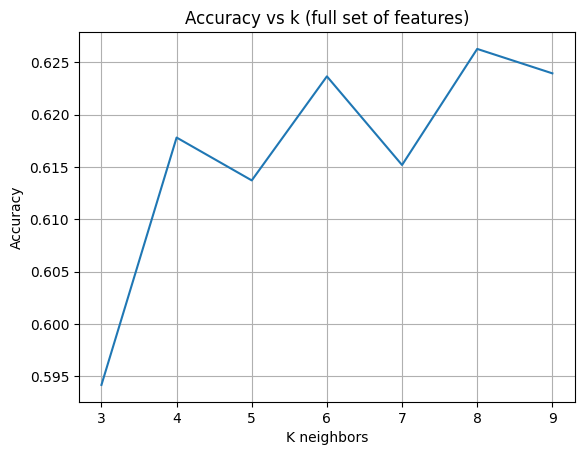

In [9]:
accuracyscore=[]
k_list=range(3,10)
for k in k_list:
    model = KNeighborsClassifier(n_neighbors=k)
    scaler=StandardScaler()
    vec = DictVectorizer(sparse=False)
    pipeline = Pipeline([
        ("vec",vec),
        ("scaler", scaler),
        ("model", model)
    ])
    # define the training data
    X_train = diff_df[features]
    y_train = diff_df['home_win']
    X_train=X_train.to_dict(orient="records")

    accuracyscore.append(cross_validate(pipeline, X_train, y_train, cv=10,scoring="accuracy",return_train_score=True)['test_score'].mean())
plt.plot(k_list,accuracyscore)
plt.title("Accuracy vs k (full set of features)")
plt.grid()
plt.xlabel("K neighbors")
plt.ylabel("Accuracy")

In [10]:
1343/3425

0.39211678832116786

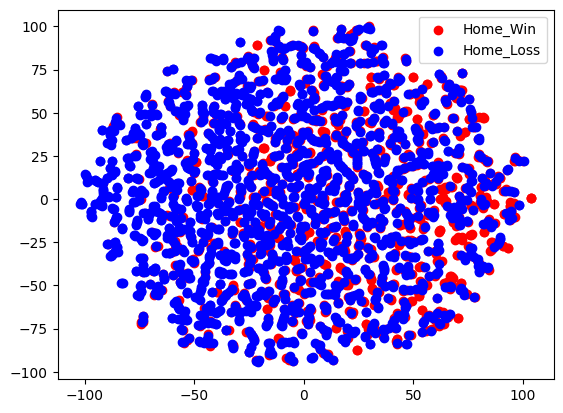

In [11]:
scaler=StandardScaler()
vec = DictVectorizer(sparse=False)
X=vec.fit_transform(diff_df[features].to_dict(orient="records"))
X=scaler.fit_transform(X)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=3).fit_transform(X)
plt.scatter(X_embedded[diff_df['home_win']==1,0], X_embedded[diff_df['home_win']==1,1],c="red",label="Home_Win")
plt.scatter(X_embedded[diff_df['home_win']==0,0], X_embedded[diff_df['home_win']==0,1],c="blue",label="Home_Loss")
plt.legend()

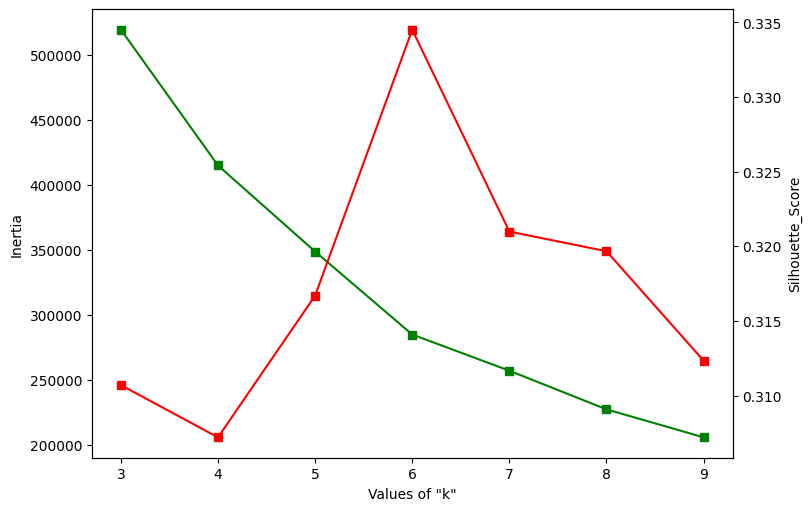

In [12]:

X=np.array(df[["field_goals_made","field_goals_attempted"]])
elbow_plot,silhouette_avg={},{}
for i in range(3,10):
  model = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(X)
  labels=model.predict(X)
  silhouette_avg[i] = silhouette_score(X, labels)
  elbow_plot[i]=model.inertia_

fig, host = plt.subplots(figsize=(8,5), layout='constrained') # (width, height) in inches

ax2 = host.twinx()

host.set_xlabel('Values of "k"')
host.set_ylabel("Inertia")
ax2.set_ylabel("Silhouette_Score")

p1 = host.plot(elbow_plot.keys(), elbow_plot.values(), 'gs-')
p2 = ax2.plot( silhouette_avg.keys(), silhouette_avg.values(), 'rs-')

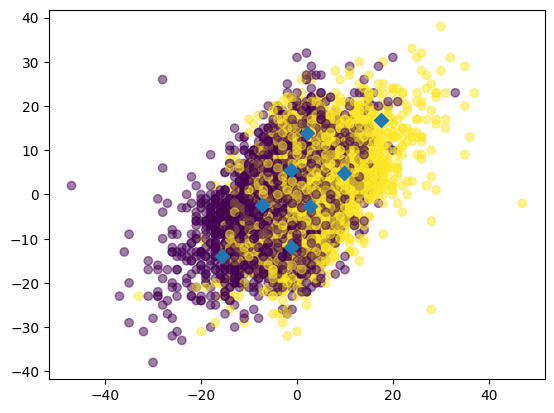

In [13]:
model = KMeans(n_clusters=8, random_state=0, n_init="auto").fit(X)
labels=model.labels_
# Assign the columns of new_points: xs and ys
xs = X[:,0]
ys = X[:,1]
# Make a scatter plot of xs and ys, using labels to define the colors
plt.scatter(xs,ys,c=df['home'],alpha=0.5)
# Assign the cluster centers: centroids
centroids = model.cluster_centers_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.show()

In [14]:
test_df=sdv.mbb.load_mbb_player_boxscore(seasons=range(2021,2022))
test_df

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


game_id,season,season_type,game_date,game_date_time,athlete_id,athlete_display_name,team_id,team_name,team_location,team_short_display_name,minutes,field_goals_made,field_goals_attempted,three_point_field_goals_made,three_point_field_goals_attempted,free_throws_made,free_throws_attempted,offensive_rebounds,defensive_rebounds,rebounds,assists,steals,blocks,turnovers,fouls,points,starter,ejected,did_not_play,active,athlete_jersey,athlete_short_name,athlete_headshot_href,athlete_position_name,athlete_position_abbreviation,team_display_name,team_uid,team_slug,team_logo,team_abbreviation,team_color,team_alternate_color,home_away,team_winner,team_score,opponent_team_id,opponent_team_name,opponent_team_location,opponent_team_display_name,opponent_team_abbreviation,opponent_team_logo,opponent_team_color,opponent_team_alternate_color,opponent_team_score
i32,i32,i32,date,"datetime[μs, America/New_York]",i32,str,i32,str,str,str,f64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,bool,bool,bool,bool,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,i32,i32,str,str,str,str,str,str,str,i32
401310865,2021,3,2021-04-05,2021-04-05 21:20:00 EDT,4395692,"""Flo Thamba""",239,"""Bears""","""Baylor""","""Baylor""",16.0,0,3,0,0,3,4,3,3,6,0,0,1,1,5,3,true,false,false,false,"""0""","""F. Thamba""","""https://a.espn…","""Forward""","""F""","""Baylor Bears""","""s:40~l:41~t:23…","""baylor-bears""","""https://a.espn…","""BAY""","""154734""","""ffb81c""","""away""",true,86,2250,"""Bulldogs""","""Gonzaga""","""Gonzaga Bulldo…","""GONZ""","""https://a.espn…","""041e42""","""c8102e""",70
401310865,2021,3,2021-04-05,2021-04-05 21:20:00 EDT,4395695,"""Jared Butler""",239,"""Bears""","""Baylor""","""Baylor""",31.0,6,14,4,9,6,6,0,3,3,7,0,0,0,3,22,true,false,false,false,"""12""","""J. Butler""","""https://a.espn…","""Guard""","""G""","""Baylor Bears""","""s:40~l:41~t:23…","""baylor-bears""","""https://a.espn…","""BAY""","""154734""","""ffb81c""","""away""",true,86,2250,"""Bulldogs""","""Gonzaga""","""Gonzaga Bulldo…","""GONZ""","""https://a.espn…","""041e42""","""c8102e""",70
401310865,2021,3,2021-04-05,2021-04-05 21:20:00 EDT,4278053,"""Davion Mitchel…",239,"""Bears""","""Baylor""","""Baylor""",36.0,6,15,1,4,2,2,1,5,6,5,1,1,3,1,15,true,false,false,false,"""45""","""D. Mitchell""","""https://a.espn…","""Guard""","""G""","""Baylor Bears""","""s:40~l:41~t:23…","""baylor-bears""","""https://a.espn…","""BAY""","""154734""","""ffb81c""","""away""",true,86,2250,"""Bulldogs""","""Gonzaga""","""Gonzaga Bulldo…","""GONZ""","""https://a.espn…","""041e42""","""c8102e""",70
401310865,2021,3,2021-04-05,2021-04-05 21:20:00 EDT,4067696,"""MaCio Teague""",239,"""Bears""","""Baylor""","""Baylor""",31.0,8,15,2,3,1,2,0,2,2,0,0,1,1,0,19,true,false,false,false,"""31""","""M. Teague""","""https://a.espn…","""Guard""","""G""","""Baylor Bears""","""s:40~l:41~t:23…","""baylor-bears""","""https://a.espn…","""BAY""","""154734""","""ffb81c""","""away""",true,86,2250,"""Bulldogs""","""Gonzaga""","""Gonzaga Bulldo…","""GONZ""","""https://a.espn…","""041e42""","""c8102e""",70
401310865,2021,3,2021-04-05,2021-04-05 21:20:00 EDT,4066292,"""Mark Vital""",239,"""Bears""","""Baylor""","""Baylor""",27.0,3,7,0,1,0,0,8,3,11,2,2,1,0,3,6,true,false,false,false,"""11""","""M. Vital""","""https://a.espn…","""Guard""","""G""","""Baylor Bears""","""s:40~l:41~t:23…","""baylor-bears""","""https://a.espn…","""BAY""","""154734""","""ffb81c""","""away""",true,86,2250,"""Bulldogs""","""Gonzaga""","""Gonzaga Bulldo…","""GONZ""","""https://a.espn…","""041e42""","""c8102e""",70
401310865,2021,3,2021-04-05,2021-04-05 21:20:00 EDT,4432284,"""Zach Loveday""",239,"""Bears""","""Baylor""","""Baylor""",1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,false,false,false,false,"""32""","""Z. Loveday""","""https://a.espn…","""Forward""","""F""","""Baylor Bears""","""s:40~l:41~t:23…","""baylor-bears""","""https://a.espn…","""BAY""","""154734""","""ffb81c""","""away""",true,86,2250,"""Bulldogs""","""Gonzaga""","""Gonzaga Bu